In [12]:
#Import Python Required Libraries for plotting and Linear Regression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import 

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

#Step 1-  Read Dataframe and understand
Boombike = pd.read_csv('day.csv')
#Highlevel view of data
Boombike.head()
#understand data elements - null data present or not
Boombike.info
#Data Statistics - Mean, Median Mode for all fields. Get first hand information without getting in to analysis
Boombike.describe()
#Check for Null values - If any column contains null data that need to be addressed
Boombike.isnull().sum()

#Drop fields which have no impact on target variable - cnt
#Apparently fields instant, dteday, casual and registered does not seem to have impact and will be dropped
Boombike.drop(['instant'],axis=1,inplace=True)
Boombike.drop(['dteday'],axis=1,inplace=True)
Boombike.drop(['casual'],axis=1,inplace=True)
Boombike.drop(['registered'],axis=1,inplace=True)
#Checking dataset after dropping the insignificant columns
Boombike.head()

#Check Correlation data
Boombike.corr()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
season,1.000000e+00,-3.279074e-16,8.310321e-01,-0.010868,-0.003081,0.013762,0.021306,0.333361,0.342014,0.208220,-0.229607,0.404584
yr,-3.279074e-16,1.000000e+00,-5.162656e-16,0.008195,-0.005466,-0.002945,-0.050322,0.048789,0.047215,-0.112547,-0.011624,0.569728
mnth,8.310321e-01,-5.162656e-16,1.000000e+00,0.018905,0.009523,-0.004688,0.045613,0.219083,0.226430,0.224937,-0.208013,0.278191
holiday,-1.086804e-02,8.195345e-03,1.890483e-02,1.000000,-0.101962,-0.252948,-0.034395,-0.028764,-0.032703,-0.015662,0.006257,-0.068764
weekday,-3.081198e-03,-5.466369e-03,9.522969e-03,-0.101962,1.000000,0.035800,0.031112,-0.000168,-0.007539,-0.052290,0.014283,0.067534
workingday,1.376178e-02,-2.945396e-03,-4.687953e-03,-0.252948,0.035800,1.000000,0.060236,0.053470,0.052940,0.023202,-0.018666,0.062542
weathersit,2.130636e-02,-5.032247e-02,4.561335e-02,-0.034395,0.031112,0.060236,1.000000,-0.119503,-0.120559,0.590277,0.039769,-0.295929
temp,3.333607e-01,4.878919e-02,2.190833e-01,-0.028764,-0.000168,0.053470,-0.119503,1.000000,0.991696,0.128565,-0.158186,0.627044
atemp,3.420139e-01,4.721519e-02,2.264302e-01,-0.032703,-0.007539,0.052940,-0.120559,0.991696,1.000000,0.141512,-0.183876,0.630685
hum,2.082196e-01,-1.125471e-01,2.249368e-01,-0.015662,-0.052290,0.023202,0.590277,0.128565,0.141512,1.000000,-0.248506,-0.098543


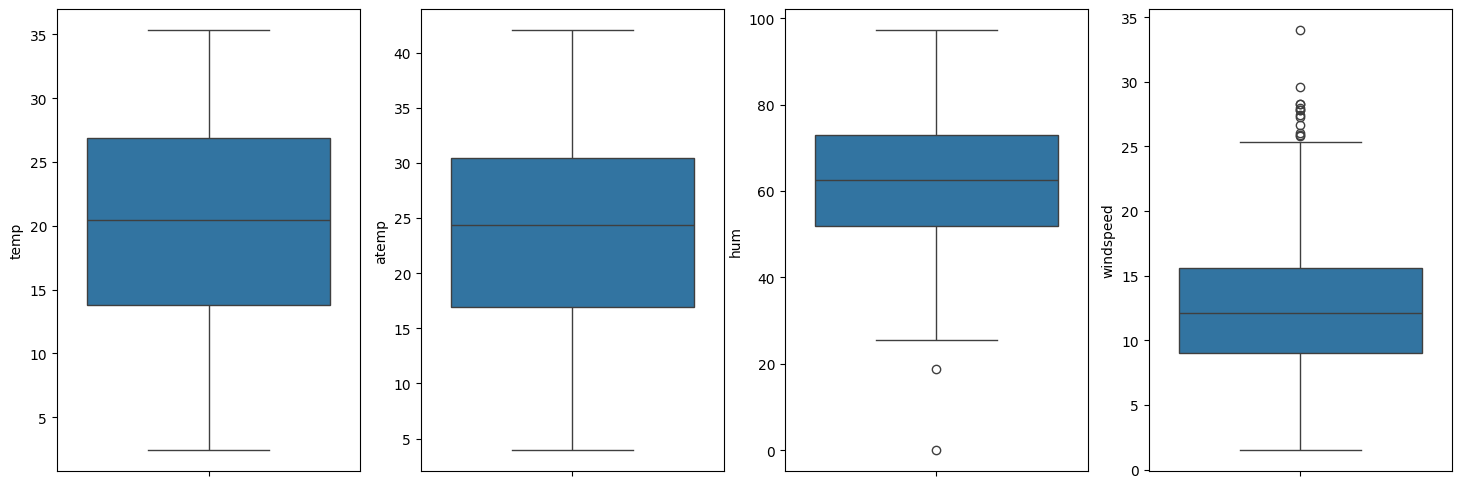

In [13]:
#Check for Outliers based on  boxplot on continuous variables - temp, atemp, hum, atemp
cols = ['temp', 'atemp', 'hum', 'windspeed']
plt.figure(figsize=(18,6))
k = 1
for col in cols:
    plt.subplot(1,4,k)
    sns.boxplot(y=col, data=Boombike)
    k+=1
#As per boxplot below Windspeed and hum have some outliers but not significant number of them

In [18]:
#Convert Categorical data in to apprehensive one
Boombike.season.replace({1:"spring", 2:"summer", 3:"fall", 4:"winter"},inplace = True)
Boombike.weathersit.replace({1:'good',2:'medium',3:'bad',4:'severe'},inplace = True)
Boombike.mnth = Boombike.mnth.replace({1: 'jan',2: 'feb',3: 'mar',4: 'apr',5: 'may',6: 'jun',7: 'jul',8: 'aug',9: 'sept',10: 'oct',11: 'nov',12: 'dec'})
Boombike.weekday = Boombike.weekday.replace({0: 'sun',1: 'mon',2: 'tue',3: 'wed',4: 'thu',5: 'fri',6: 'sat'})
Boombike.head()
#Below data provides better readability and inference can be more easier and relatable

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,0,jan,0,sat,0,moderate,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,jan,0,sun,0,moderate,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,jan,0,mon,1,good,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,jan,0,tue,1,good,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,jan,0,wed,1,good,9.305237,11.46350,43.6957,12.522300,1600


<Figure size 1000x2000 with 0 Axes>

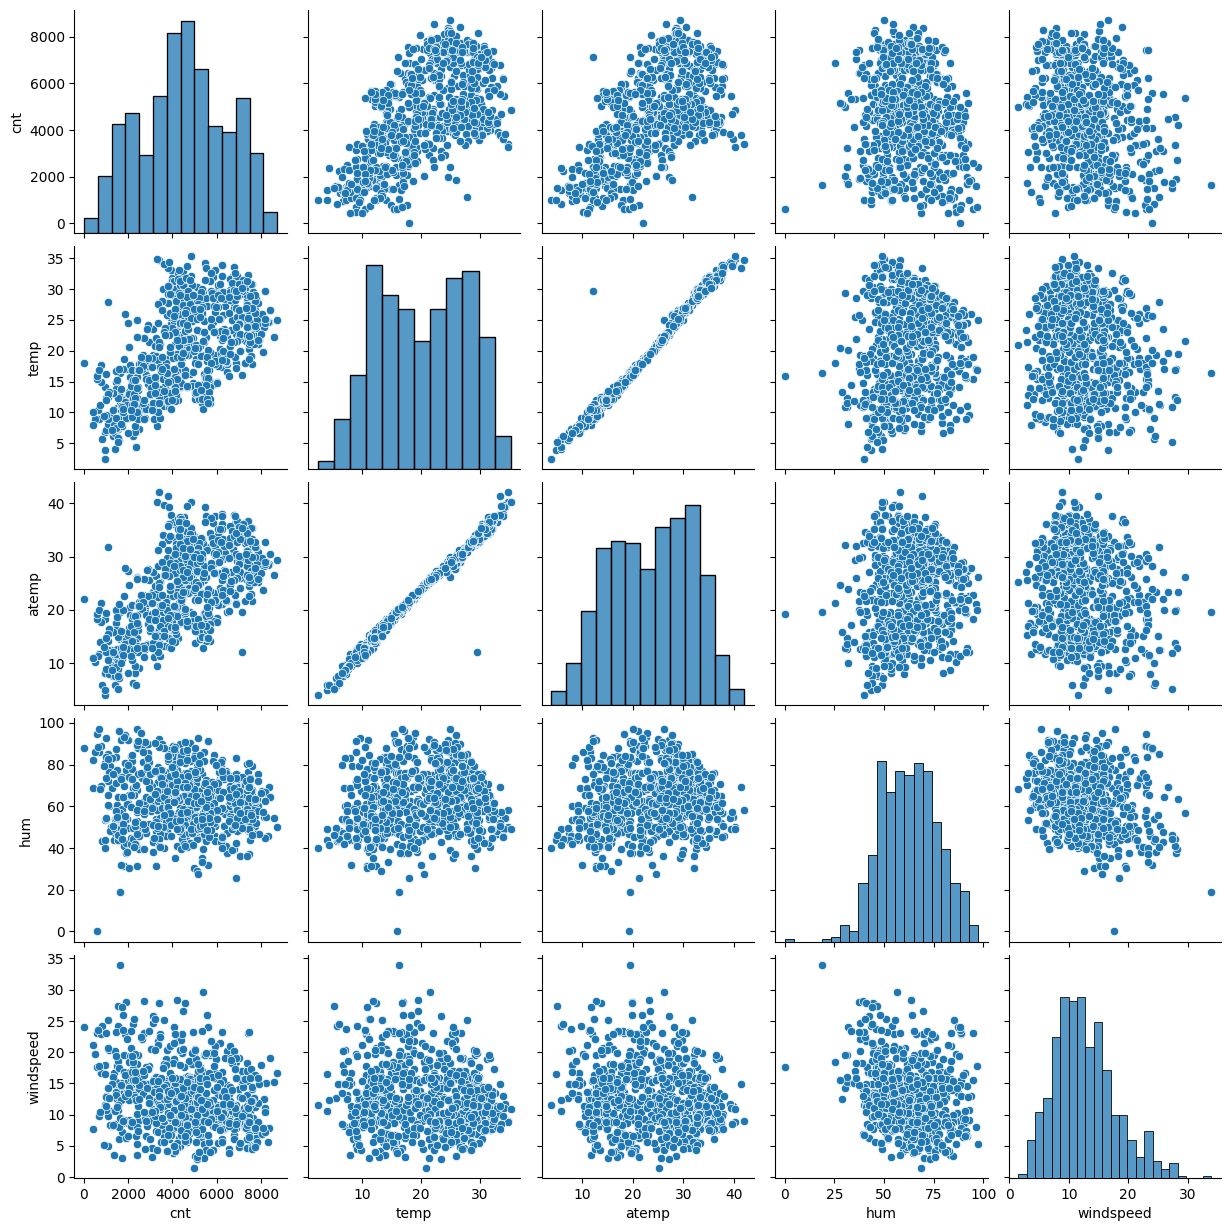

In [19]:
#Perform linearity check for the Continuous variables
plt.figure(figsize = (10,20))
sns.pairplot(data=Boombike,vars=['cnt', 'temp', 'atemp', 'hum','windspeed'])
plt.show()
#temp and atemp seems to be more linealy aligned with cnt 
#hum and windspeed doesn't show any interesting trend

<Figure size 2000x1500 with 0 Axes>

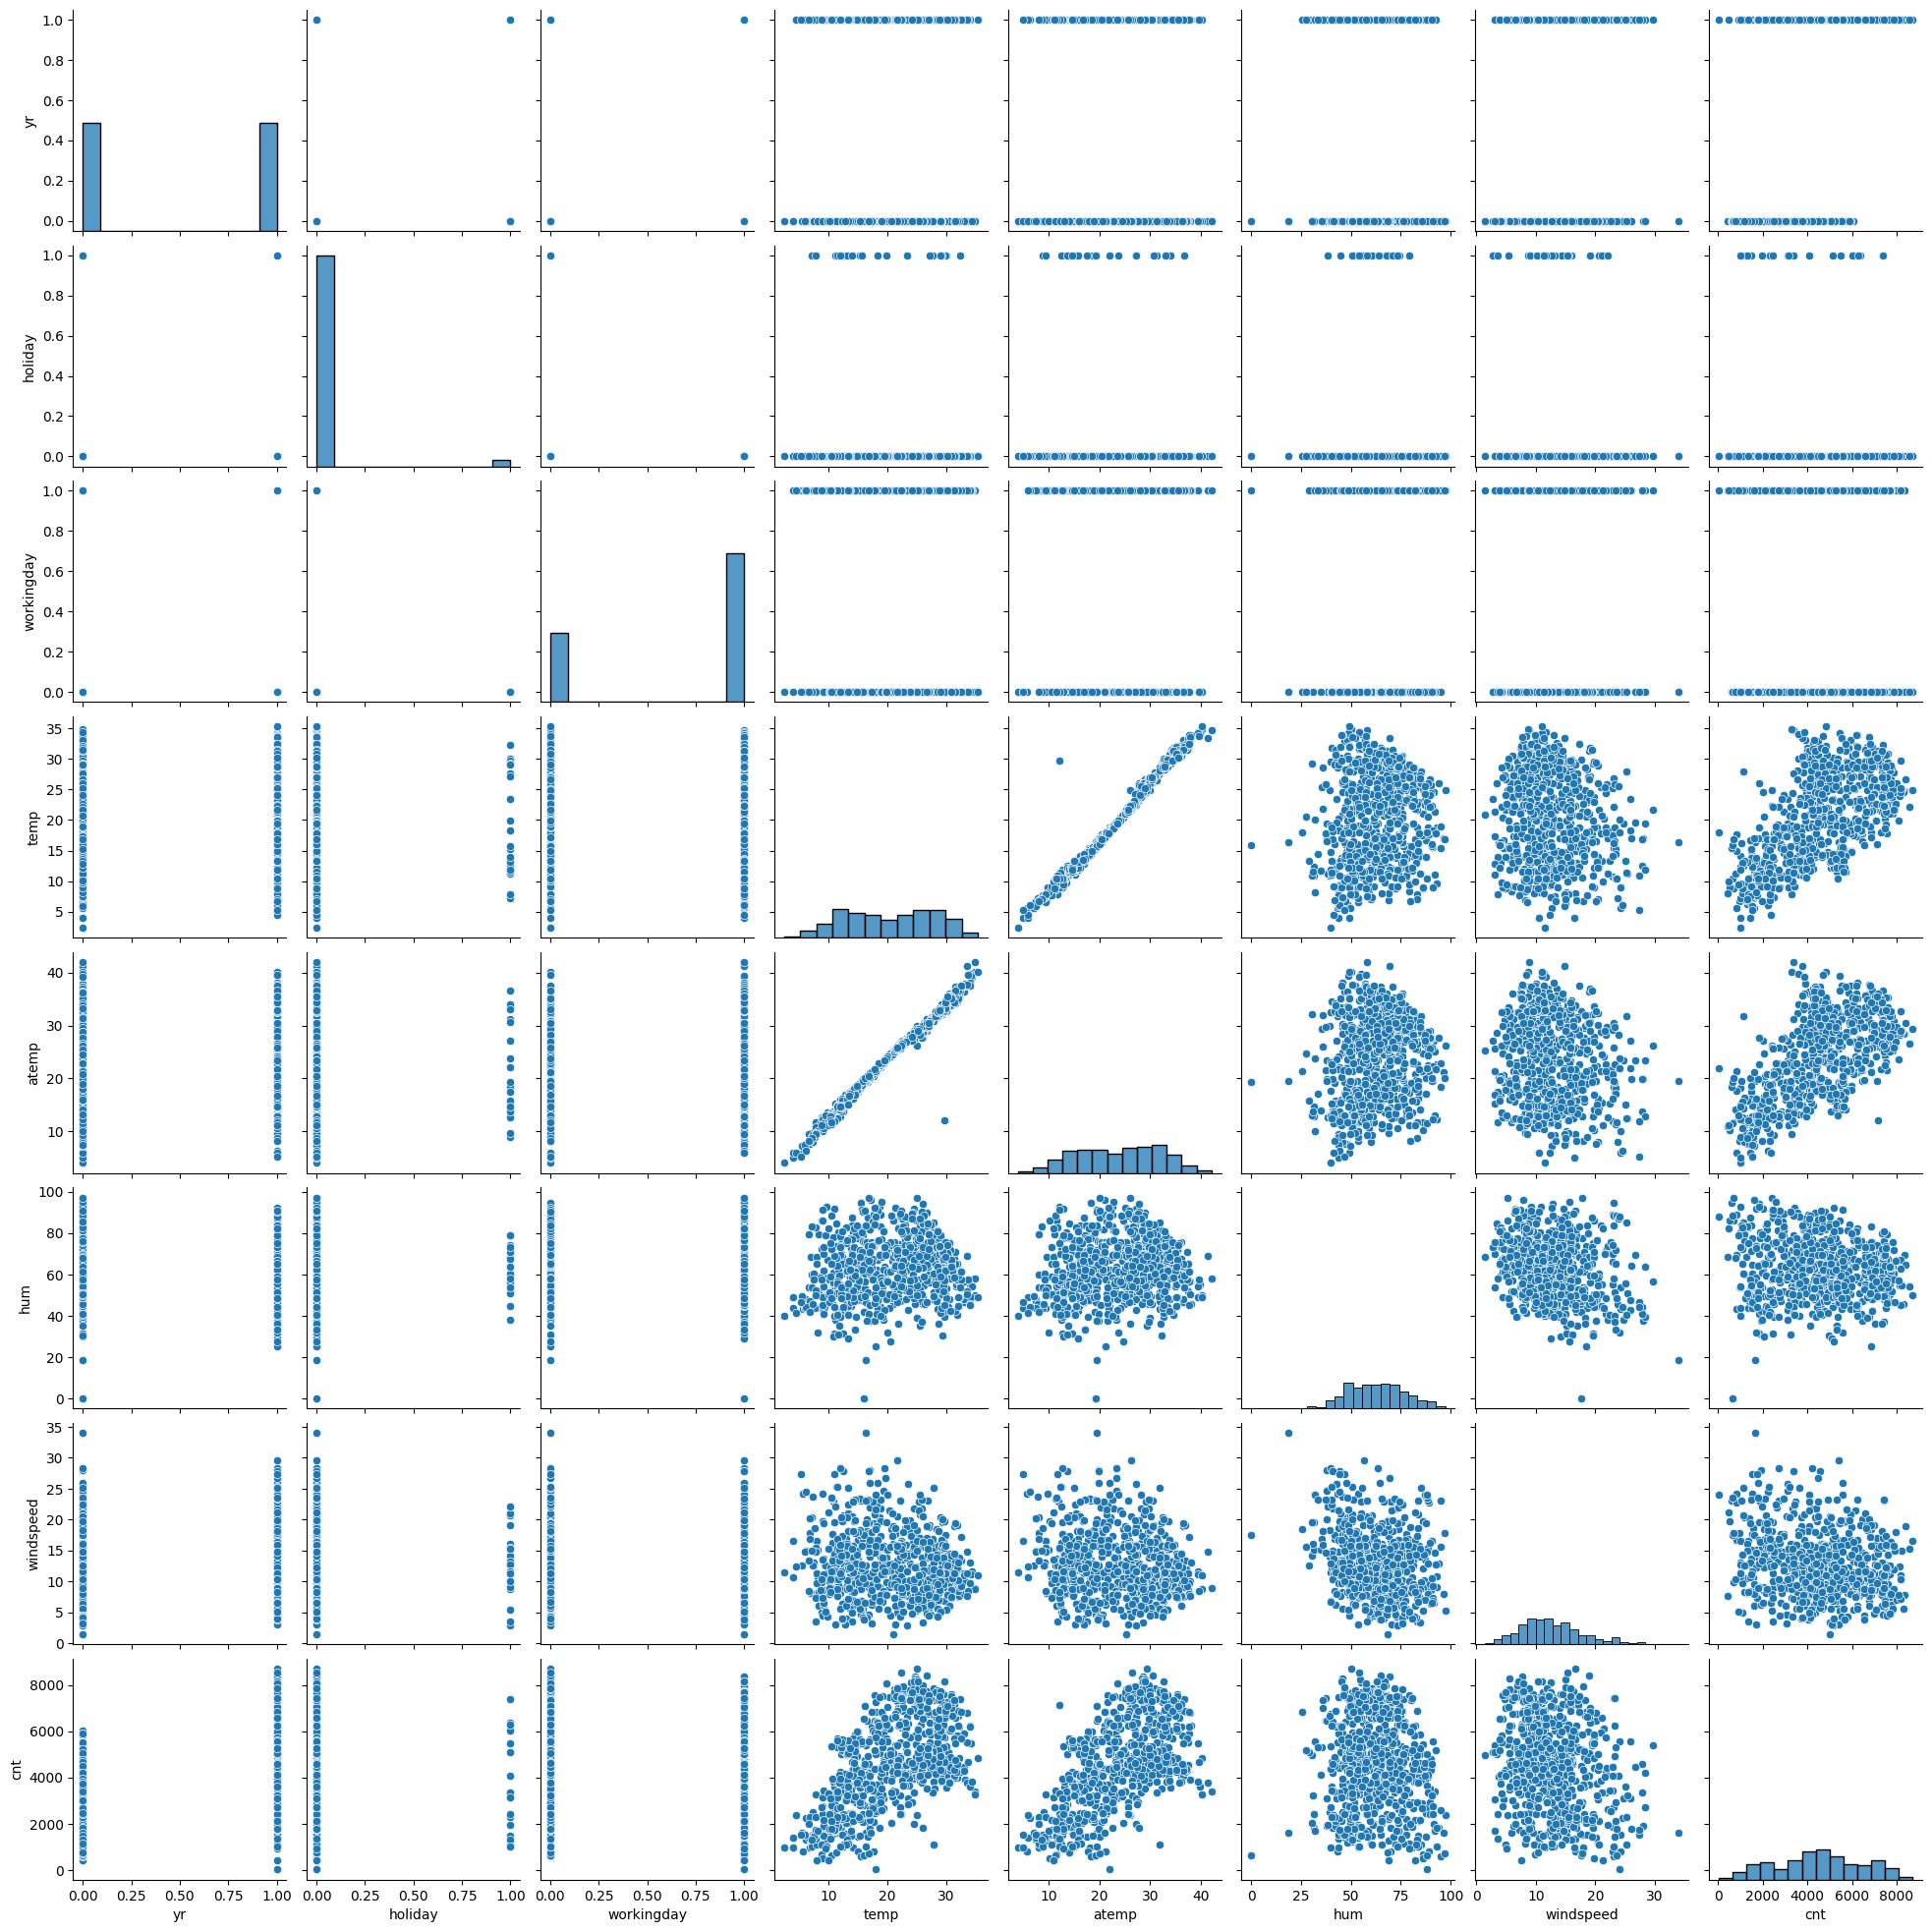

In [20]:
#Lets plot relationship for all the numerical variables

plt.figure(figsize=(20,15))
sns.pairplot(Boombike)
plt.show()

In [36]:
Boombike = pd.read_csv('day.csv')
#Dummy Variables
Boombike = pd.get_dummies(data=Boombike,columns=["season","mnth","weekday"],drop_first=True)
Boombike = pd.get_dummies(data=Boombike,columns=["weathersit"])

#Train Test Split

y=Boombike.pop('cnt')
X=Boombike

#Train Test split with 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size =0.8,test_size=0.2, random_state=100)
X.head()

,instant,dteday,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,...,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3
0,1,1/1/2018,0,0,0,14.110847,18.18125,80.5833,10.749882,331,...,False,False,False,False,False,False,True,False,True,False
1,2,2/1/2018,0,0,0,14.902598,17.68695,69.6087,16.652113,131,...,False,False,False,False,False,False,False,False,True,False
2,3,3/1/2018,0,0,1,8.050924,9.47025,43.7273,16.636703,120,...,False,True,False,False,False,False,False,True,False,False
3,4,4/1/2018,0,0,1,8.200000,10.60610,59.0435,10.739832,108,...,False,False,True,False,False,False,False,True,False,False
4,5,5/1/2018,0,0,1,9.305237,11.46350,43.6957,12.522300,82,...,False,False,False,True,False,False,False,True,False,False


In [45]:
#Checking shape and size for train and test
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)



(584, 34)
(146, 34)
(584,)
(146,)


In [51]:
#Scaling continuous variables
num_vars = ['temp','atemp','hum','windspeed']
scaler = MinMaxScaler()
#Fit and transform training set only
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_train.head()
X_train[num_vars].describe()

,temp,atemp,hum,windspeed
count,584.000000,584.000000,584.000000,584.000000
mean,0.537414,0.513175,0.649499,0.319463
std,0.225336,0.211663,0.144219,0.168114
min,0.000000,0.000000,0.000000,0.000000
25%,0.340113,0.331819,0.535852,0.199177
50%,0.545191,0.530558,0.653714,0.294764
75%,0.736512,0.690521,0.752361,0.410413
max,1.000000,1.000000,1.000000,1.000000


In [59]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
lr = LinearRegression()
lr.fit(X_train,y_train)
rfe = RFE(lr,15)
rfe.fit(X_train,y_train)
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

#Function to build a model using statsmodel api
def build_model(cols):
    X_train_sm = sm.add_constant(X_train[cols])
    lm = sm.OLS(y_train, X_train_sm).fit()
    print(lm.summary())
    return lm
def get_vif(cols):
    df1 = X_train[cols]
    vif = pd.DataFrame()
    vif['Features'] = df1.columns
    vif['VIF'] = [variance_inflation_factor(df1.values, i) for i in range(df1.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    print(vif.sort_values(by='VIF',ascending=False))
X_train.columns[rfe.support_]
X_train_rfe = X_train[['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'season_spring',
       'season_summer', 'season_winter', 'mnth_jan', 'mnth_jul', 'mnth_sept', 'weekday_sat',
       'weathersit_bad', 'weathersit_moderate']]

#Model 1 - All columns
cols = ['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'season_spring',
       'season_summer', 'season_winter', 'mnth_jan', 'mnth_jul', 'mnth_sept', 'weekday_sat',
       'weathersit_bad', 'weathersit_moderate']

build_model(cols)
get_vif(cols)



ValueError: could not convert string to float: '3/1/2019'